# Challenge: Edit MNIST challenge images to be correctly predicted

Goal: Edit the images placed in `data/MNIST/challenge` so that the provided model predicts the correct label while keeping more than 60% of the original pixels unchanged.

Description: You are given a pre-trained `SmallCNN` model and a small set of challenge images. Your task is to minimally modify these images so the model classifies them correctly. This exercise encourages you to: 
- Explore the sample dataset in `data/MNIST/sample` to understand variation and typical inputs.
- Use explainable AI (XAI) techniques (saliency maps, Grad-CAM, Integrated Gradients, occlusion, etc.) to discover what parts of the image the model relies on.
- Propose minimal edits (pixel changes, small masks, subtle color shifts) that change model prediction while preserving at least 60% of the original pixels.

Deliverables: For each edited image, save the modified image to `data/MNIST/challenge/edited/` alongside a short report (less than 2 pages) describing the XAI insights you used and the percentage of pixels preserved. For ease of use, you have the images already in that folder and you can directly work on them. You are allowed to use any external program you want to modify the image (i.e., paint, photoshop, figma, ...).

The practice can be done by more than 1 person. Final grade would depend on the number of images correctly edited (n_images_correct) with their corresponding report and number of persons working together (n_persons) following the next formula:
$$grade = 2,5 \times n\_images\_correct - 2,5 * (n\_persons - 1)$$


In [14]:
# Imports and device
import torch
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import numpy as np
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from captum.attr import Saliency

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

C:\Users\javir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda


In [2]:
# SmallCNN definition (must match the trained model architecture)
class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(12*7*7, 12)
        self.fc2 = nn.Linear(12, num_classes)

    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))  # 14x14
        x = self.pool(x)                      # 7x7
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.nn.functional.relu(self.fc1(x)))
        return self.fc2(x)

# convenience transform
to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()

In [3]:
models_dir = Path('../models')
model_name = models_dir / 'small_cnn.pth'
model = torch.load(model_name, weights_only=False)
model.to(device) 
model.eval()

SmallCNN(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=588, out_features=12, bias=True)
  (fc2): Linear(in_features=12, out_features=10, bias=True)
)

0_label5.png: Pred: 1, Label: 5
1_label3.png: Pred: 1, Label: 3
2_label3.png: Pred: 1, Label: 3
3_label7.png: Pred: 3, Label: 7
4_label2.png: Pred: 6, Label: 2


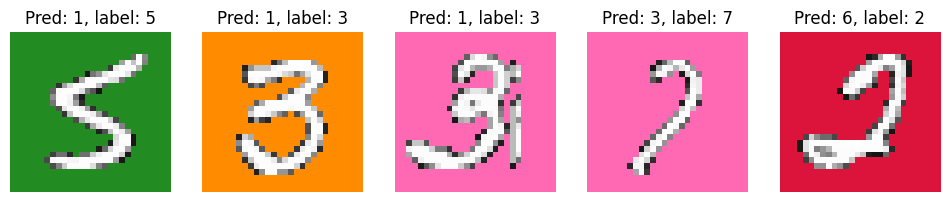

In [4]:
# Load the images in data/MNIST/challenge/ and plot them. Label of the image is the last character of the filename.
challenge_dir = Path('../data/data/MNIST/challenge')
image_files = list(challenge_dir.glob('*.png'))
fig, axes = plt.subplots(1, len(image_files), figsize=(12,4))
for ax, img_file in zip(axes, image_files):
    img = to_tensor(Image.open(img_file)).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img)
        pred = output.argmax(dim=1).item()
    ax.imshow(to_pil(img.squeeze().cpu()))
    ax.set_title(f'Pred: {pred}, label: {img_file.stem[-1]}')
    ax.axis('off')
    print(f'{img_file.name}: Pred: {pred}, Label: {img_file.stem[-1]}')
plt.show()

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device).eval()

IMG_SIZE = 28

preprocess = Compose([
    Resize((IMG_SIZE, IMG_SIZE)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # change to your training stats if needed
])
to_vis = Compose([
    Resize((IMG_SIZE, IMG_SIZE)),
    ToTensor(),   # [0,1] for overlay
])
# --- 3) Captum Saliency setup ---
saliency = Saliency(model)

def compute_saliency(img_path, target_class):
    pil = Image.open(img_path).convert("RGB")
    x = preprocess(pil).unsqueeze(0).to(device)        # model input
    x_vis = to_vis(pil).unsqueeze(0)                   # for overlay

    # gradient wrt chosen class (set target_class=None for predicted class)
    attr = saliency.attribute(x, target=target_class)  # [1,C,H,W]
    sal = attr.abs().squeeze(0).detach().cpu().numpy() # [C,H,W] or [H,W]
    if sal.ndim == 3:
        sal = sal.max(axis=0)                          # reduce channels

    # normalize to [0,1]
    sal = (sal - sal.min()) / (sal.max() - sal.min() + 1e-8)

    img_np = x_vis[0].permute(1,2,0).cpu().numpy()     # [H,W,3] or [H,W,1]
    ponderation = 0.1
    overlay = np.clip(ponderation*img_np + (1-ponderation)*sal[...,None], 0, 1)
    return img_np, sal, overlay

# --- 4) Run on your images ---
target_class = 3  # <- set the class you want
fig, axes = plt.subplots(1, len(image_files), figsize=(14,4))
for ax, path in zip(axes, image_files):
    img_np, sal, overlay = compute_saliency(path, target_class)
    if img_np.shape[2] == 1:
        ax.imshow(overlay.squeeze(), cmap="gray")
    else:
        ax.imshow(overlay)
    ax.set_title(f"Saliency (class={target_class})\n{IMG_SIZE}×{IMG_SIZE}")
    ax.axis("off")
plt.tight_layout(); plt.show()


C:\Users\javir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\captum\attr\_core\saliency.py:129: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)


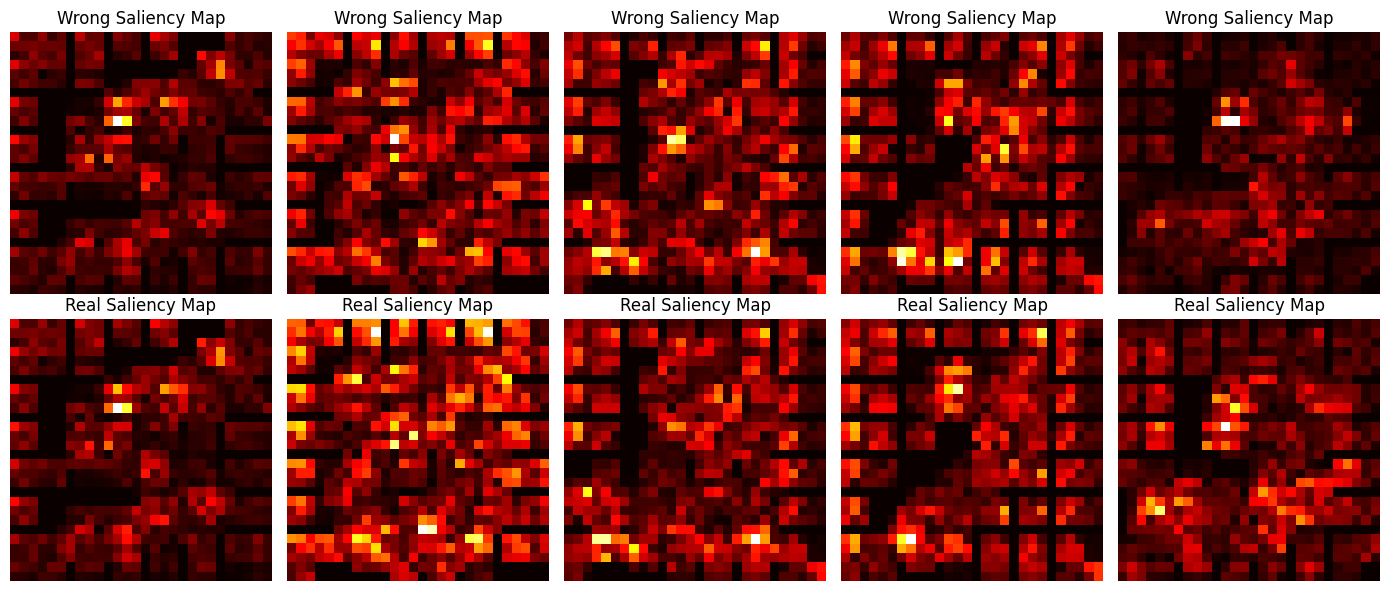

In [23]:
wrong_maps = []
for target_class, path  in zip([1,1,1,3,6], image_files) :
    img_np, sal, overlay = compute_saliency(path, target_class)
    wrong_maps.append(sal)

real_maps = []
for real_class, path in zip([5,3,3,7,2], image_files):
    img_np, sal, overlay = compute_saliency(path, real_class)
    real_maps.append(sal)

fig, axes = plt.subplots(2, len(image_files), figsize=(14,6))
for ax, sal in zip(axes[0], wrong_maps):
    ax.imshow(sal, cmap="hot")
    ax.set_title(f"Wrong Saliency Map")
    ax.axis("off")
for ax, sal in zip(axes[1], real_maps):
    ax.imshow(sal, cmap="hot")
    ax.set_title(f"Real Saliency Map")
    ax.axis("off")
plt.tight_layout(); plt.show()        

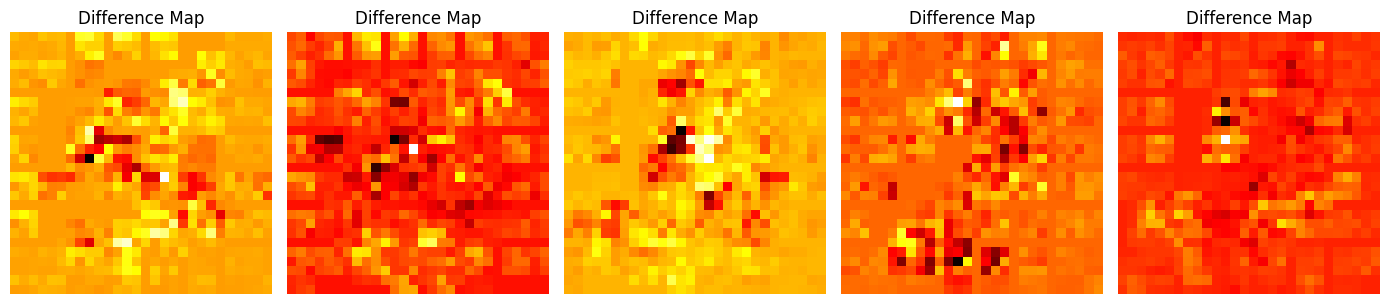

In [24]:
#subtract wrong from real
diff_maps = []
for real_sal, wrong_sal in zip(real_maps, wrong_maps):
    diff = real_sal - wrong_sal
    diff_maps.append(diff)
fig, axes = plt.subplots(1, len(image_files), figsize=(14,4))
for ax, sal in zip(axes, diff_maps):
    ax.imshow(sal, cmap="hot")
    ax.set_title(f"Difference Map")
    ax.axis("off")
plt.tight_layout(); plt.show()

In [25]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch

def detect_background_color(img_np, tol=0.05):
    """
    Estimate background color from the image edges using median color.
    img_np: [H,W,3] in [0,1] or [H,W,1] in [0,1]
    Returns bg_color as shape (3,) for RGB or (1,) for grayscale, and a function is_bg(pixels)
    """
    H, W = img_np.shape[:2]
    # collect edge pixels
    top = img_np[0, :, :]
    bottom = img_np[-1, :, :]
    left = img_np[:, 0, :]
    right = img_np[:, -1, :]
    edges = np.concatenate([top, bottom, left, right], axis=0)  # [N,C]

    # background = channel-wise median
    bg_color = np.median(edges, axis=0)

    # distance threshold to consider "background"
    def is_bg(pix):
        # pix [...,C]; Euclidean distance
        d = np.linalg.norm(pix - bg_color, axis=-1)
        return d < tol

    return bg_color, is_bg

def top_k_most_negative_mask(diff, frac=0.40):
    """
    Select up to frac of *all pixels*, but only among negative diffs.
    diff: [H,W] numpy array (can be torch tensor -> use .cpu().numpy())
    """
    if isinstance(diff, torch.Tensor):
        diff = diff.detach().cpu().numpy()
    flat = diff.flatten()
    neg_idx = np.where(flat < 0)[0]
    if len(neg_idx) == 0:
        return np.zeros_like(diff, dtype=bool)

    # how many pixels to flip at most
    k = int(np.floor(frac * flat.size))
    if k <= 0:
        return np.zeros_like(diff, dtype=bool)

    # among negatives, take the k *most negative* (lowest values)
    neg_vals = flat[neg_idx]
    order = np.argsort(neg_vals)  # ascending -> most negative first
    pick = neg_idx[order[:min(k, len(neg_idx))]]

    mask = np.zeros_like(flat, dtype=bool)
    mask[pick] = True
    return mask.reshape(diff.shape)

def apply_color_rules(img_np, mask, bg_color, white_thresh=0.95, black_thresh=0.05, bg_tol=0.05):
    """
    Within 'mask', swap:
      - white or black -> background
      - background     -> white
      - else           -> unchanged
    img_np in [0,1]; bg_color shape (C,)
    """
    out = img_np.copy()
    C = out.shape[2]

    # helpers
    if C == 3:
        intensity = out.mean(axis=2)
        is_white = intensity > white_thresh
        is_black = intensity < black_thresh
        # background predicate
        d = np.linalg.norm(out - bg_color[None, None, :], axis=-1)
        is_bg = d < bg_tol

        # apply inside mask only
        # background -> white
        sel_bg = mask & is_bg
        out[sel_bg] = np.array([1.0, 1.0, 1.0], dtype=out.dtype)

        # white or black -> background
        sel_wb = mask & (is_white | is_black)
        out[sel_wb] = bg_color

    else:  # grayscale C==1
        intensity = out[..., 0]
        is_white = intensity > white_thresh
        is_black = intensity < black_thresh
        is_bg = np.abs(intensity - bg_color[0]) < bg_tol

        sel_bg = mask & is_bg
        out[sel_bg, 0] = 1.0

        sel_wb = mask & (is_white | is_black)
        out[sel_wb, 0] = bg_color[0]

    return out



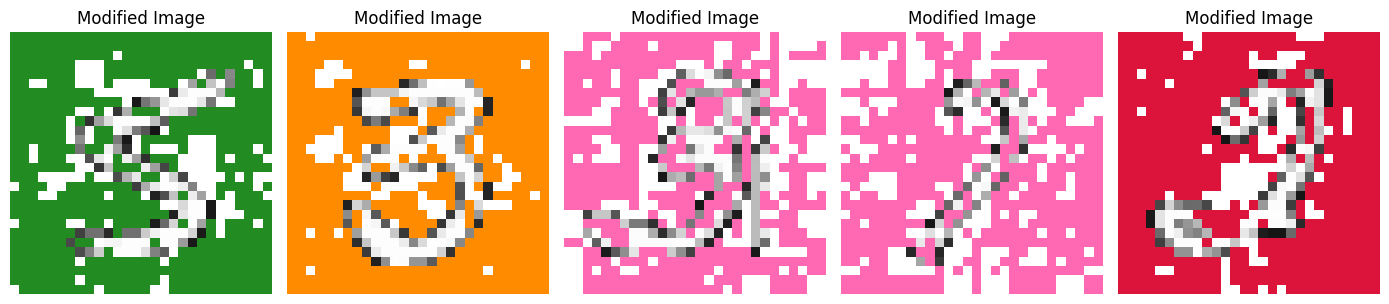

In [26]:
# ---------- MAIN LOOP (replace your code with this) ----------
modified_images = []
for path, diff in zip(image_files, diff_maps):
    pil = Image.open(path).convert("RGB")
    x_vis = to_vis(pil).unsqueeze(0)                      # [1,C,H,W], [0,1]
    img_np = x_vis[0].permute(1,2,0).cpu().numpy()        # [H,W,3] or [H,W,1]

    # 1) detect background from edges
    bg_color, _is_bg = detect_background_color(img_np)

    # 2) select only the 40% most negative diffs (cap)
    #    ensure diff is [H,W] np array
    if isinstance(diff, torch.Tensor):
        diff_np = diff.detach().cpu().numpy()
    else:
        diff_np = diff
    if diff_np.ndim == 3:  # e.g., [H,W,1]
        diff_np = diff_np.squeeze()
    mask_40 = top_k_most_negative_mask(diff_np, frac=0.40)

    # 3) apply color rules within mask
    modified_img = apply_color_rules(img_np, mask_40, bg_color)

    modified_images.append(modified_img)

# show
fig, axes = plt.subplots(1, len(image_files), figsize=(14,4))
for ax, mod_img in zip(axes, modified_images):
    if mod_img.shape[2] == 1:
        ax.imshow(mod_img.squeeze(), cmap="gray")
    else:
        ax.imshow(mod_img)
    ax.set_title("Modified Image")
    ax.axis("off")
plt.tight_layout(); plt.show()


In [27]:
save_dir = challenge_dir / 'edited'
for modified_image, img_file in zip(modified_images, image_files):
    # save
    save_path = save_dir / img_file.name
    pil_img = to_pil(torch.tensor(modified_image).permute(2,0,1))  # C,H,W
    pil_img.save(save_path)    

---
### Any code you want to add, put it below this markdown cell

Podemos observar como los fondos rosas, verdes y naranjas solo son clases de números impares {1,3,5,7,9}. Morado azul y rojo solo son clases pares {0,2,4,6,8}.

In [28]:
import torch

def smoothgrad(model, img, target=None, n_samples=50, noise_std=0.1, clip=(0.0, 1.0), abs_grad=False):
    """
    SmoothGrad for a single image tensor.
    img: [1, C, H, W] in [0,1]
    returns: (target_class:int, saliency:[1,1,H,W] in [0,1])
    """
    model.eval()

    # choose target on the clean image if not provided
    with torch.no_grad():
        logits = model(img)
        if target is None:
            target = int(logits.argmax(dim=1).item())

    grads = []
    for _ in range(n_samples):
        noisy = img + noise_std * torch.randn_like(img)
        if clip is not None:
            noisy = noisy.clamp(*clip)
        noisy.requires_grad_(True)

        # forward
        out = model(noisy)
        score = out[0, target]

        # backward
        model.zero_grad(set_to_none=True)
        if noisy.grad is not None:
            noisy.grad.zero_()
        score.backward()

        grads.append(noisy.grad.detach())

    # average gradients across noisy samples
    grads = torch.stack(grads, dim=0).mean(dim=0)  # [1,C,H,W]
    if abs_grad:
        grads = grads.abs()

    # collapse channels to 1 map
    sal = grads.mean(dim=1, keepdim=True)         # [1,1,H,W]

    # normalize to [0,1]
    sal_min, sal_max = sal.amin(dim=(2,3), keepdim=True), sal.amax(dim=(2,3), keepdim=True)
    sal = (sal - sal_min) / (sal_max - sal_min + 1e-8)

    return target, sal

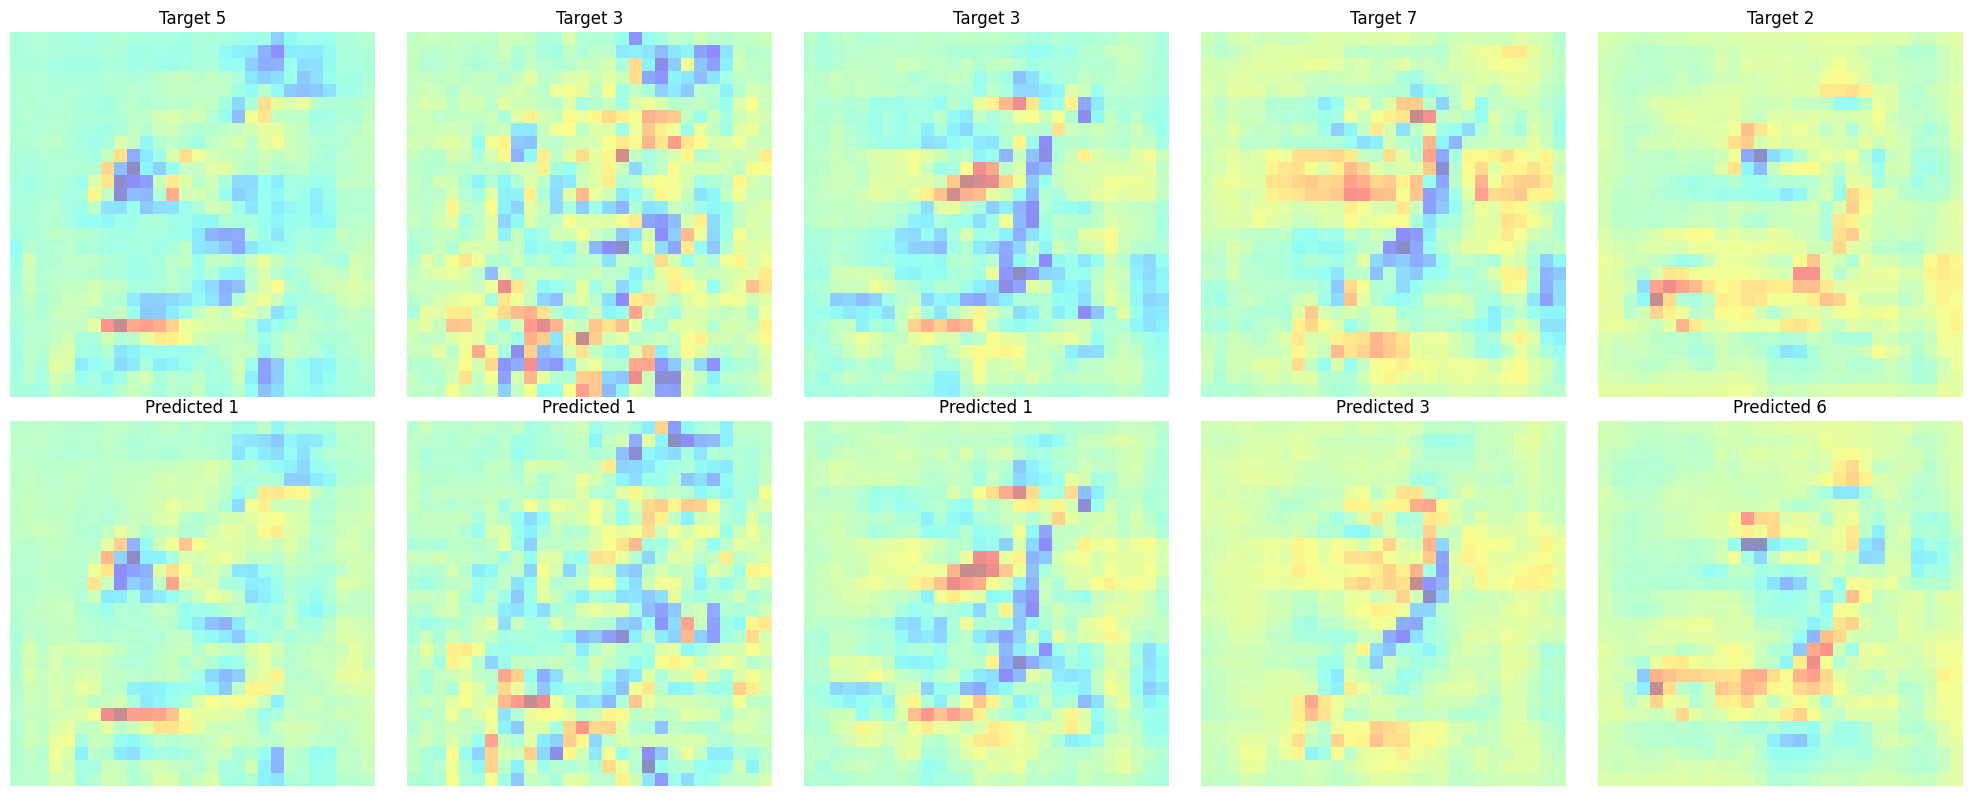

In [ ]:
n_samples = 150
noise_std = 0.4
initial_values = [5, 3, 3, 7, 2]
predicted_values = [1, 1, 1, 3, 6]

objective_smoothgrads = []
contrary_smoothgrads = []

n_imgs = len(image_files)

# 2 rows (top: correct class, bottom: wrong class)
fig, axes = plt.subplots(2, n_imgs, figsize=(4 * n_imgs, 8))

for col, (img_file, initial_value, predicted_value) in enumerate(zip(image_files, initial_values, predicted_values)):
    img = to_tensor(Image.open(img_file)).unsqueeze(0).to(device)

    # Compute SmoothGrad for both classes
    target, sal = smoothgrad(model, img, n_samples=n_samples, noise_std=noise_std, target=initial_value)
    target_wrong, sal_wrong = smoothgrad(model, img, n_samples=n_samples, noise_std=noise_std, target=predicted_value)

    # Convert to numpy for plotting
    img_np = img.squeeze().permute(1, 2, 0).cpu().numpy()
    sal_np = sal.squeeze().cpu().numpy()
    sal_np_wrong = sal_wrong.squeeze().cpu().numpy()

    objective_smoothgrads.append(sal_np)
    contrary_smoothgrads.append(sal_np_wrong)

    # --- Top row: correct class SmoothGrad ---
    # axes[0, col].imshow(img_np)
    axes[0, col].imshow(sal_np, cmap='jet', alpha=0.45)
    axes[0, col].set_title(f"Target {initial_value}")
    axes[0, col].axis('off')

    # --- Bottom row: wrong prediction SmoothGrad ---
    # axes[1, col].imshow(img_np)
    axes[1, col].imshow(sal_np_wrong, cmap='jet', alpha=0.45)
    axes[1, col].set_title(f"Predicted {predicted_value}")
    axes[1, col].axis('off')

plt.tight_layout()
plt.show()

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms.functional import to_tensor

# params
percent_to_change = 0.05   # 40% lowest pixels
alpha = 0.41            # strength of the modification (tune 0.05–0.3)

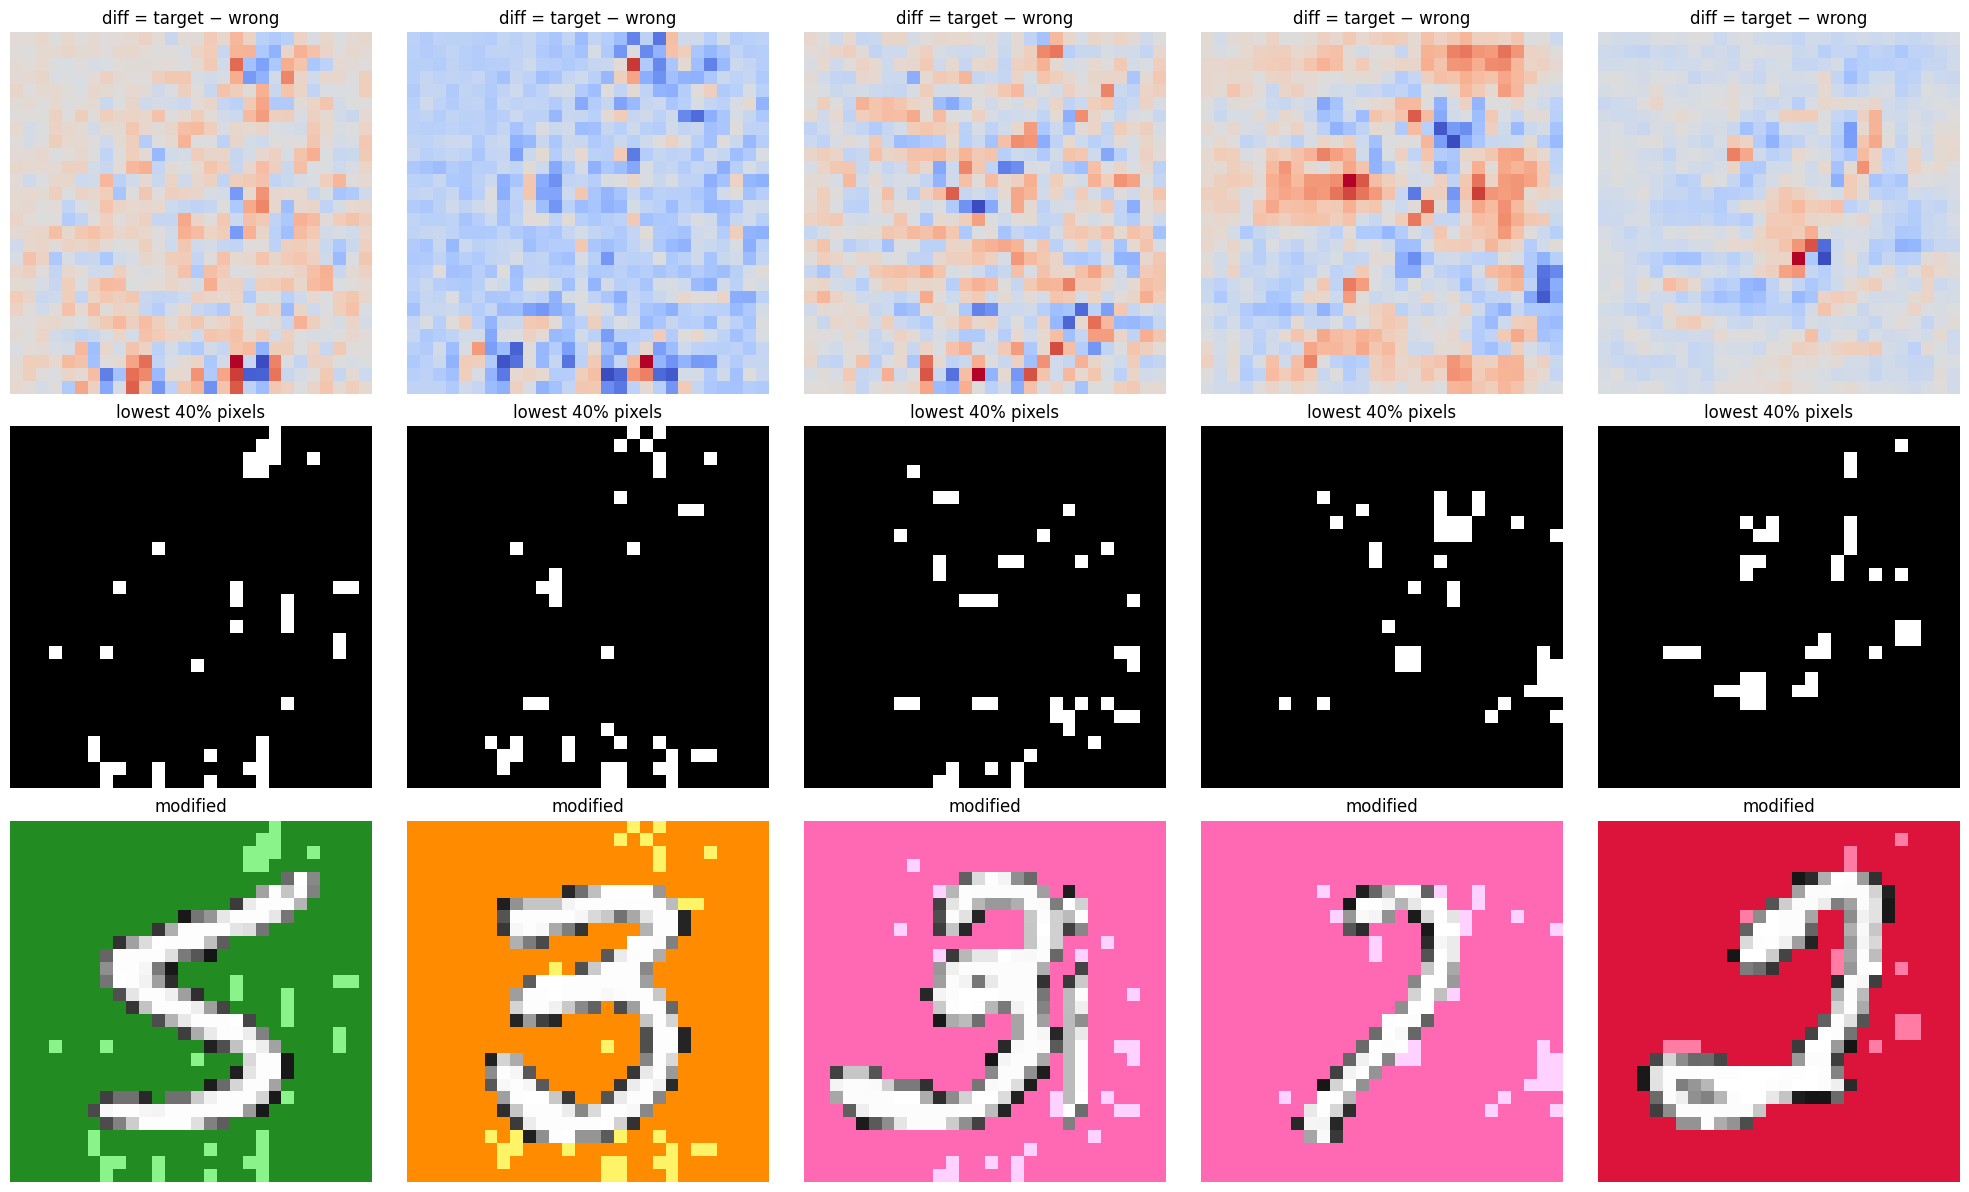

In [31]:

assert len(objective_smoothgrads) == len(contrary_smoothgrads) == len(image_files)
n_imgs = len(image_files)

diff_maps = []
masks_40 = []
imgs_before = []
imgs_after  = []

for img_file, sal_obj, sal_wrong in zip(image_files, objective_smoothgrads, contrary_smoothgrads):
    # diff: positive -> favors target; negative -> favors wrong
    diff = sal_obj - sal_wrong                        # H x W
    H, W = diff.shape
    diff_maps.append(diff)

    # select lowest 40% pixels
    k = int(np.floor(percent_to_change * H * W))
    flat_idx = np.argpartition(diff.ravel(), k)[:k]   # indices of k smallest values
    mask = np.zeros(H * W, dtype=bool)
    mask[flat_idx] = True
    mask = mask.reshape(H, W)                         # H x W (True on selected pixels)
    masks_40.append(mask)

    # load image as [H,W,C] in [0,1]
    img_np = np.asarray(Image.open(img_file).convert("RGB"), dtype=np.float32) / 255.0
    imgs_before.append(img_np)

    # apply modification only on selected pixels (all channels)
    mod = img_np.copy()
    mod += (alpha * mask[..., None])                  # brighten selected pixels across RGB
    mod = np.clip(mod, 0.0, 1.0)
    imgs_after.append(mod)

# --- visualize ---
cols = n_imgs
fig, axes = plt.subplots(3, cols, figsize=(4*cols, 12))

for i in range(n_imgs):
    # row 0: diff map
    ax = axes[0, i] if n_imgs > 1 else axes[0]
    dm = diff_maps[i]
    dm_norm = (dm - dm.min()) / (dm.max() - dm.min() + 1e-8)
    ax.imshow(dm_norm, cmap='coolwarm')
    ax.set_title("diff = target − wrong")
    ax.axis('off')

    # row 1: mask (lowest 40%)
    ax = axes[1, i] if n_imgs > 1 else axes[1]
    ax.imshow(masks_40[i], cmap='gray')
    ax.set_title("lowest 40% pixels")
    ax.axis('off')

    # row 2: modified image
    ax = axes[2, i] if n_imgs > 1 else axes[2]
    ax.imshow(imgs_after[i])
    ax.set_title("modified")
    ax.axis('off')

plt.tight_layout()
plt.show()


In [32]:
with torch.no_grad():
    for img_file, mod_np in zip(image_files, imgs_after):
        x_mod = torch.from_numpy(mod_np).permute(2,0,1).unsqueeze(0).to(device).float()
        pred_after = model(x_mod).argmax(dim=1).item()
        print(f"{img_file}: new prediction → {pred_after}")

..\data\data\MNIST\challenge\0_label5.png: new prediction → 7
..\data\data\MNIST\challenge\1_label3.png: new prediction → 1
..\data\data\MNIST\challenge\2_label3.png: new prediction → 1
..\data\data\MNIST\challenge\3_label7.png: new prediction → 1
..\data\data\MNIST\challenge\4_label2.png: new prediction → 6


In [33]:
changes = np.arange(0.05, 0.4, 0.01).tolist()
alphas = np.arange(0.05, 0.95, 0.01).tolist()

n_image = 4

works = []
for i in changes:
    for j in alphas:
        diff = objective_smoothgrads[n_image] - contrary_smoothgrads[n_image]   # To try to do the first                     # H x W
        H, W = diff.shape
        diff_maps.append(diff)

        # select lowest 40% pixels
        k = int(np.floor(i * H * W))
        flat_idx = np.argpartition(diff.ravel(), k)[:k]   # indices of k smallest values
        mask = np.zeros(H * W, dtype=bool)
        mask[flat_idx] = True
        mask = mask.reshape(H, W)                         # H x W (True on selected pixels)
        masks_40.append(mask)

        # load image as [H,W,C] in [0,1]
        img_np = np.asarray(Image.open(image_files[n_image]).convert("RGB"), dtype=np.float32) / 255.0
        imgs_before.append(img_np)

        # apply modification only on selected pixels (all channels)
        mod = img_np.copy()
        mod += (j * mask[..., None])                  # brighten selected pixels across RGB
        mod = np.clip(mod, 0.0, 1.0)

        # see if the prediction is what we want
        x_mod = torch.from_numpy(mod).permute(2,0,1).unsqueeze(0).to(device).float()
        pred_after = model(x_mod).argmax(dim=1).item()
        # print(f"{img_file}: new prediction → {pred_after}")
        if pred_after == initial_values[n_image]:
            print(i,j)
            works.append(x_mod)

In [34]:
save_dir = challenge_dir / 'edited'
for modified_image, img_file in zip(imgs_after, image_files):
    # save
    save_path = save_dir / img_file.name
    pil_img = to_pil(torch.tensor(modified_image).permute(2,0,1))  # C,H,W
    pil_img.save(save_path)   

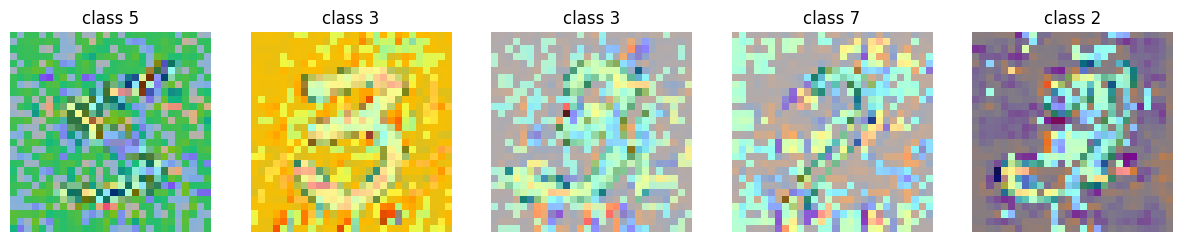

In [43]:
modified_samples = 50
noise_std = 0.1

imgs = []
for img_file in image_files:
    img = to_tensor(Image.open(img_file)).unsqueeze(0).to(device)  # [1,C,H,W]
    imgs.append(img)

fig, axes = plt.subplots(1, len(imgs), figsize=(15, 5))
axes = np.array(axes).reshape(-1)    # asegura array plano


for ax, img in zip(axes, imgs):
    target, sal = smoothgrad(model, img,
                             n_samples=modified_samples,
                             noise_std=noise_std)

    # show base image
    ax.imshow(to_pil(img.squeeze().cpu()))
    # overlay saliency
    ax.imshow(sal.squeeze().cpu(), cmap='jet', alpha=0.45)
    ax.set_title(f"class {target}")
    ax.axis('off')


In [36]:
# Check percentage of editing an image
def calculate_edit_percentage(original_img, edited_img):
    original_pixels = original_img.load()
    edited_pixels = edited_img.load()
    width, height = original_img.size
    total_pixels = width * height
    changed_pixels = 0

    for x in range(width):
        for y in range(height):
            if original_pixels[x, y] != edited_pixels[x, y]:
                changed_pixels += 1

    return (changed_pixels / total_pixels) * 100

Final Prediction: 5, True Label: 5, Edit Percentage: 39.92%


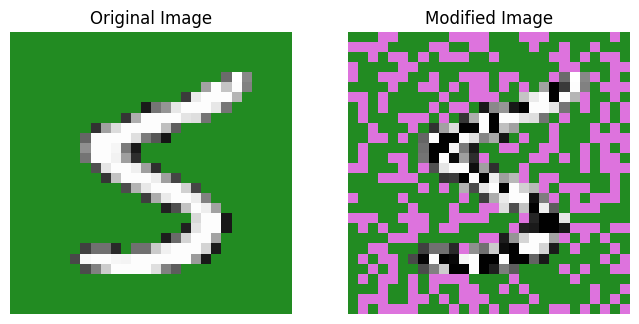

Guardado en: ..\data\data\MNIST\challenge\edited\0_label5.png


In [37]:
#SOLUCION PARA IMAGEN 0, FUERZA BRUTA CON RESETS
image_idx = 0
import random
img_path = image_files[image_idx]
label = int(img_path.stem[-1])   
img = to_tensor(Image.open(img_path).convert("RGB")).unsqueeze(0).to(device)

modified_img = img.clone()

# pred inicial
with torch.no_grad():
    output = model(modified_img)
    pred = output.argmax(dim=1).item()

iteration = 0
MAX_ITERS_BEFORE_RESET = 10000

# ============================================
# LOOP DE BÚSQUEDA + RESETS
# ============================================
while label != pred:

    if iteration >= MAX_ITERS_BEFORE_RESET:
        print(f"[RESET] Iteraciones alcanzadas ({iteration}). Reiniciando imagen...")
        modified_img = img.clone()
        iteration = 0

    modified_img = img.clone()

    #shape of modified_img: torch.Size([1, 3, 28, 28])
    percent_to_change = random.randint(20, 40) / 100.0
    indices = torch.randperm(28*28)[:int(percent_to_change * 28 * 28)]

    modified_img[0, :, indices // 28, indices % 28] = (
        1 - modified_img[0, :, indices // 28, indices % 28]
    )

    with torch.no_grad():
        output = model(modified_img)
        pred = output.argmax(dim=1).item()

    edit_percentage = calculate_edit_percentage(
        to_pil(img.squeeze().cpu()),
        to_pil(modified_img.squeeze().cpu())
    )

    iteration += 1


print(f"Final Prediction: {pred}, True Label: {label}, Edit Percentage: {edit_percentage:.2f}%")

# ============================================
# VISUALIZACIÓN
# ============================================
fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].imshow(to_pil(img.squeeze().cpu()))
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(to_pil(modified_img.squeeze().cpu()), cmap="gray")
axes[1].set_title('Modified Image')
axes[1].axis('off')

plt.show()

# ============================================
# GUARDAR IMAGEN
# ============================================
save_dir = challenge_dir / "edited"
save_dir.mkdir(exist_ok=True)

save_path = save_dir / img_path.name
modified_img_pil = to_pil(modified_img.squeeze().cpu())
modified_img_pil.save(save_path)

print("Guardado en:", save_path)

---
## Check if you have passed the challenge 

In [38]:
# Check percentage of editing an image
def calculate_edit_percentage(original_img, edited_img):
    original_pixels = original_img.load()
    edited_pixels = edited_img.load()
    width, height = original_img.size
    total_pixels = width * height
    changed_pixels = 0

    for x in range(width):
        for y in range(height):
            if original_pixels[x, y] != edited_pixels[x, y]:
                changed_pixels += 1

    return (changed_pixels / total_pixels) * 100

In [39]:
# Create edited directory
edited_dir = challenge_dir / 'final'

# Load edited images, check that they are predicted correctly and calculate edit percentages
for original_img_file, edited_img_file in zip(challenge_dir.glob('*.png'), edited_dir.glob('*.png')):
    original_img = Image.open(original_img_file)
    edited_img = Image.open(edited_img_file)
    # Convert the edited image to RGB if it's not
    if edited_img.mode != 'RGB':
        edited_img = edited_img.convert('RGB')

    # Check prediction
    img_tensor = to_tensor(edited_img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img_tensor)
        pred = output.argmax(dim=1).item()
    
    print(f'Edited {edited_img_file.name}: Pred: {pred}, Label: {original_img_file.stem[-1]}, correct: {pred == int(original_img_file.stem[-1])}')

    # Calculate edit percentage
    edit_percentage = calculate_edit_percentage(original_img, edited_img)
    print(f'Edit Percentage: {edit_percentage:.2f}%')


Edited 0_label5.png: Pred: 5, Label: 5, correct: True
Edit Percentage: 38.90%
Edited 1_label3.png: Pred: 3, Label: 3, correct: True
Edit Percentage: 29.97%
Edited 2_label3.png: Pred: 3, Label: 3, correct: True
Edit Percentage: 31.76%
Edited 3_label7.png: Pred: 7, Label: 7, correct: True
Edit Percentage: 36.48%
Edited 4_label2.png: Pred: 2, Label: 2, correct: True
Edit Percentage: 14.92%


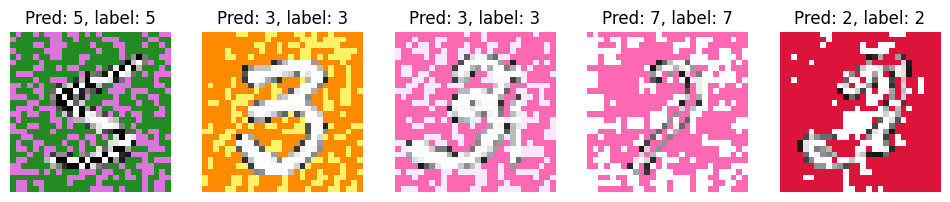

In [41]:
# Load the images in data/MNIST/challenge/ and plot them. Label of the image is the last character of the filename.
challenge_dir = Path('../data/data/MNIST/challenge/final')
image_files = list(challenge_dir.glob('*.png'))
fig, axes = plt.subplots(1, len(image_files), figsize=(12,4))
for ax, img_file in zip(axes, image_files):
    img = to_tensor(Image.open(img_file)).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img)
        pred = output.argmax(dim=1).item()
    ax.imshow(to_pil(img.squeeze().cpu()))
    ax.set_title(f'Pred: {pred}, label: {img_file.stem[-1]}')
    ax.axis('off')
plt.show()